# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

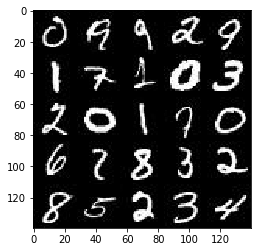

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

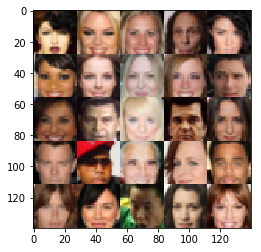

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [17]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    patch = 5
    stride = 2
    with tf.variable_scope('discriminator', reuse=reuse):
        #Input 28x28x3
        x1 = tf.layers.conv2d(images, 64, patch, strides=stride, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        #14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, patch, strides=stride, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #7x7x128
        
        #x3 = tf.layers.conv2d(relu2, 256, patch, strides=stride, padding='same')
        #bn3 = tf.layers.batch_normalization(x3, training=True)
        #relu3 = tf.maximum(alpha * bn3, bn3)
        #Hoping TF pads to 4 otherwise 3.5 x 3.5 x 256
        
        #Flatten her up
        #flat = tf.reshape(relu3, (-1, 4*4*256))
        flat = tf.reshape(relu2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [18]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    patch = 5
    stride = 2
    with tf.variable_scope('generator', reuse=not is_train):
        #Create the fully connected layer
        #x1 = tf.layers.dense(z, 4*4*256)
        x1 = tf.layers.dense(z, 7*7*128)
        #reshape
        #x1 = tf.reshape(x1, (-1, 4,4,256))
        x1 = tf.reshape(x1, (-1, 7,7,128))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #4x4x256
        
        #x2 = tf.layers.conv2d_transpose(x1, 128, patch, strides=stride, padding='same')
        x2 = tf.layers.conv2d_transpose(x1, 64, patch, strides=stride, padding='same')
        #Note - May have to come back here and reshape to 7x7
        #x2 = tf.reshape(x2, (-1, 7,7,128))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #7x7x128
        
        #x3 = tf.layers.conv2d_transpose(x2, 64, patch, strides=stride, padding='same')
        #x3 = tf.layers.batch_normalization(x3, training=is_train)
        #x3 = tf.maximum(alpha * x3, x3)
        #14x14x64
        
        #Output layer
        #logits = tf.layers.conv2d_transpose(x3, out_channel_dim, patch, strides=stride, padding='same')
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, patch, strides=stride, padding='same')
        
        #28x28x?
        
        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [19]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [20]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    #Perform optimization
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [22]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    #Build Model
    #print(data_shape[0])
    img_w, img_h, img_chan = data_shape[1], data_shape[2], data_shape[3]
    inp_real, inp_z, _ = model_inputs(img_w, img_h, img_chan, z_dim)
    d_loss, g_loss = model_loss(inp_real, inp_z, img_chan)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    display_interval = 100
    num_img_to_disp = 25
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images *= 2
                #Random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #Run optimizers
                _ = sess.run(d_opt, feed_dict={inp_real: batch_images, inp_z: batch_z})
                _ = sess.run(g_opt, feed_dict={inp_z: batch_z, inp_real: batch_images})
                
                if steps % display_interval == 0:
                    train_loss_d = d_loss.eval({inp_real: batch_images, inp_z: batch_z})
                    train_loss_g = g_loss.eval({inp_z: batch_z})
                    
                    print(  "Epoch: {} of {}".format(epoch_i, epoch_count), 
                            "D-loss: {}".format(train_loss_d),
                            "G-loss: {}".format(train_loss_g) )
                    
                    show_generator_output(sess, num_img_to_disp, inp_z, img_chan, data_image_mode)        
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 0 of 2 D-loss: 0.8616595268249512 G-loss: 2.167440891265869


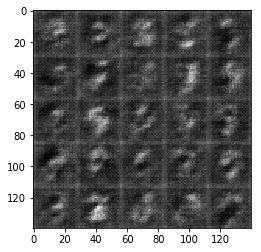

Epoch: 0 of 2 D-loss: 0.8675343990325928 G-loss: 1.3185274600982666


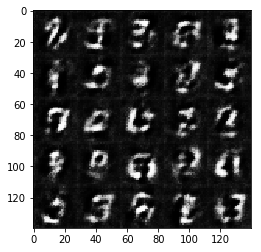

Epoch: 0 of 2 D-loss: 0.857633650302887 G-loss: 1.1829819679260254


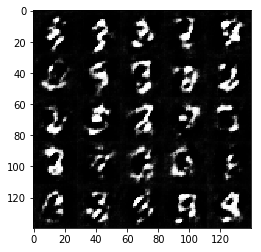

Epoch: 0 of 2 D-loss: 1.0675910711288452 G-loss: 0.6527104377746582


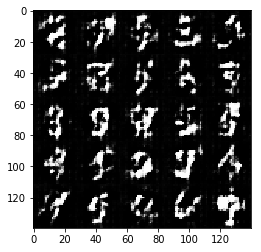

Epoch: 0 of 2 D-loss: 0.6891833543777466 G-loss: 1.4174823760986328


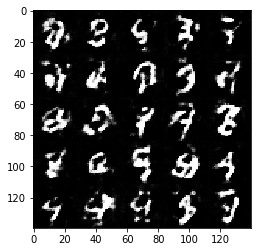

Epoch: 0 of 2 D-loss: 0.6874974966049194 G-loss: 1.0390808582305908


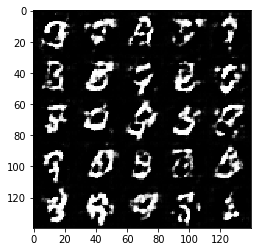

Epoch: 0 of 2 D-loss: 0.4800301194190979 G-loss: 1.4383766651153564


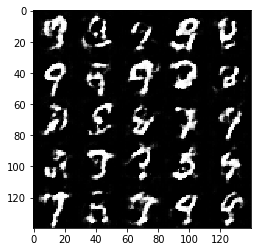

Epoch: 0 of 2 D-loss: 0.5415662527084351 G-loss: 1.7347421646118164


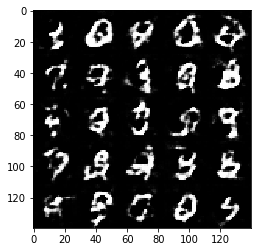

Epoch: 0 of 2 D-loss: 0.5196417570114136 G-loss: 1.3595731258392334


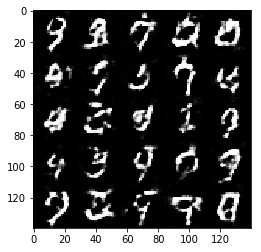

Epoch: 0 of 2 D-loss: 0.7107097506523132 G-loss: 1.2104747295379639


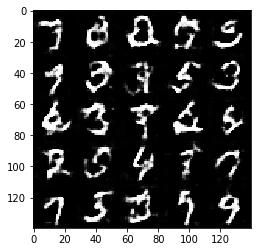

Epoch: 0 of 2 D-loss: 0.9335262775421143 G-loss: 2.414961338043213


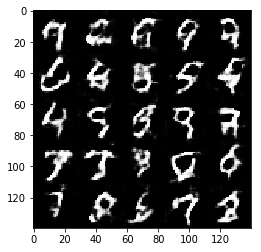

Epoch: 0 of 2 D-loss: 0.7009954452514648 G-loss: 0.9973598122596741


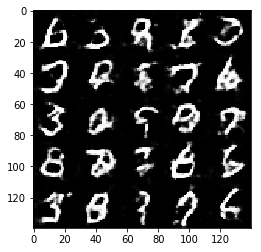

Epoch: 0 of 2 D-loss: 0.8281001448631287 G-loss: 1.7822390794754028


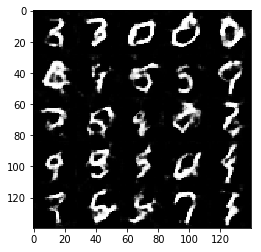

Epoch: 0 of 2 D-loss: 0.7337827682495117 G-loss: 0.898695707321167


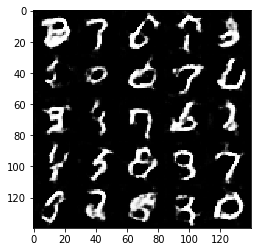

Epoch: 0 of 2 D-loss: 0.7476099729537964 G-loss: 1.1783578395843506


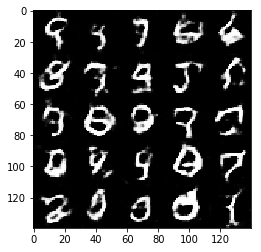

Epoch: 0 of 2 D-loss: 0.8412343859672546 G-loss: 1.0040823221206665


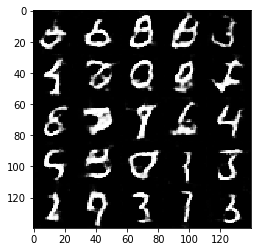

Epoch: 0 of 2 D-loss: 0.7096937894821167 G-loss: 1.2658298015594482


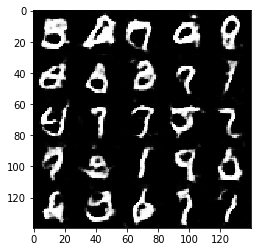

Epoch: 0 of 2 D-loss: 1.1102604866027832 G-loss: 0.528571367263794


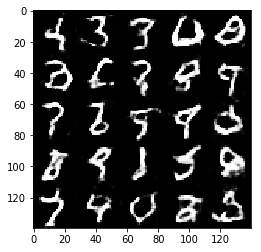

Epoch: 1 of 2 D-loss: 0.8774803280830383 G-loss: 0.9167818427085876


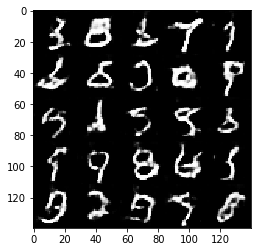

Epoch: 1 of 2 D-loss: 0.7234674692153931 G-loss: 1.8256279230117798


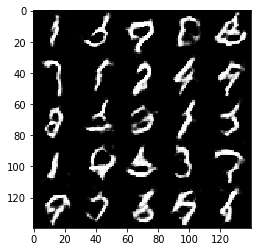

Epoch: 1 of 2 D-loss: 0.575154721736908 G-loss: 1.3799731731414795


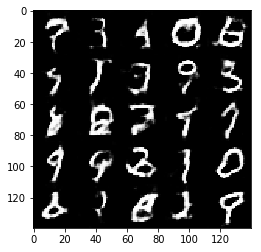

Epoch: 1 of 2 D-loss: 0.793408215045929 G-loss: 0.8805777430534363


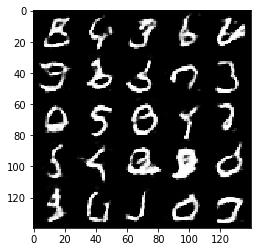

Epoch: 1 of 2 D-loss: 1.2123159170150757 G-loss: 2.8122401237487793


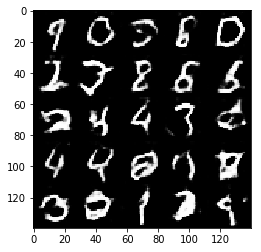

Epoch: 1 of 2 D-loss: 0.6045303344726562 G-loss: 1.32157301902771


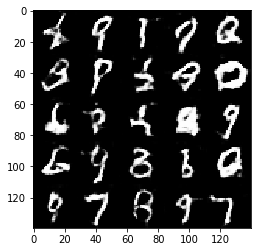

Epoch: 1 of 2 D-loss: 0.666871190071106 G-loss: 1.4181852340698242


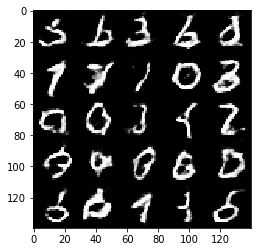

Epoch: 1 of 2 D-loss: 0.6732778549194336 G-loss: 1.5314711332321167


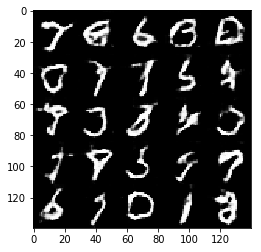

Epoch: 1 of 2 D-loss: 0.5421448945999146 G-loss: 1.4594906568527222


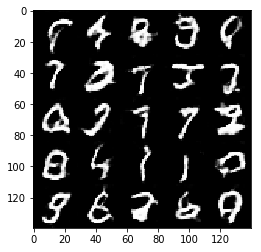

Epoch: 1 of 2 D-loss: 0.5268087983131409 G-loss: 1.8926706314086914


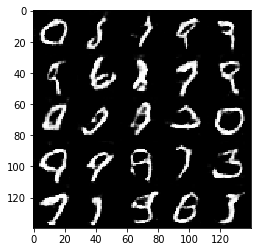

Epoch: 1 of 2 D-loss: 0.6431316137313843 G-loss: 1.0966811180114746


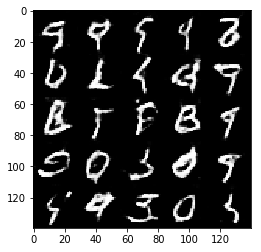

Epoch: 1 of 2 D-loss: 0.8639566898345947 G-loss: 0.8959072828292847


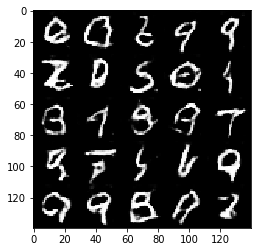

Epoch: 1 of 2 D-loss: 0.7198752164840698 G-loss: 0.9554052352905273


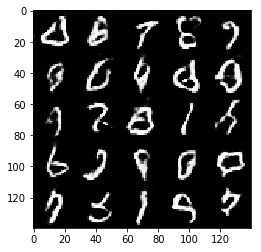

Epoch: 1 of 2 D-loss: 0.5607026815414429 G-loss: 1.2583410739898682


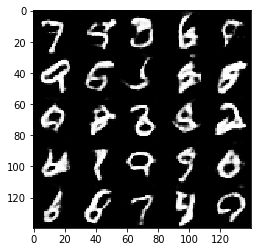

Epoch: 1 of 2 D-loss: 0.4469526708126068 G-loss: 1.4499088525772095


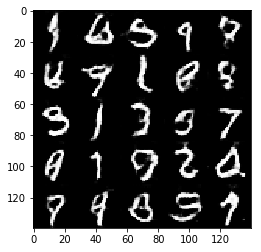

Epoch: 1 of 2 D-loss: 0.5542303919792175 G-loss: 1.8941576480865479


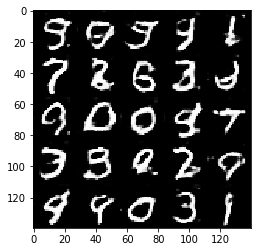

Epoch: 1 of 2 D-loss: 0.5015590190887451 G-loss: 1.3728182315826416


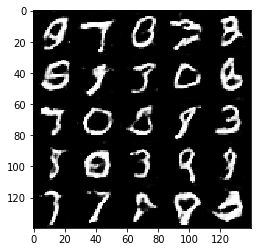

Epoch: 1 of 2 D-loss: 0.5444722771644592 G-loss: 1.3285455703735352


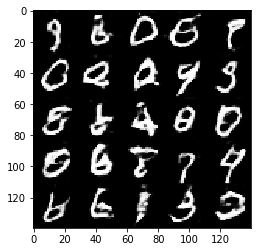

Epoch: 1 of 2 D-loss: 2.2170002460479736 G-loss: 0.179045632481575


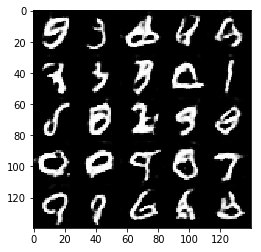

In [23]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 0 of 1 D-loss: 0.5920208692550659 G-loss: 1.791678786277771


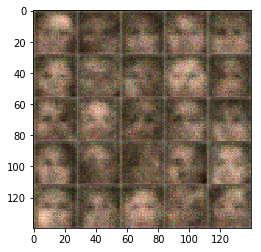

Epoch: 0 of 1 D-loss: 0.7444042563438416 G-loss: 1.1127371788024902


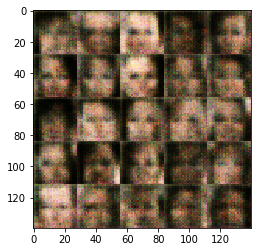

Epoch: 0 of 1 D-loss: 1.215259313583374 G-loss: 0.9635317325592041


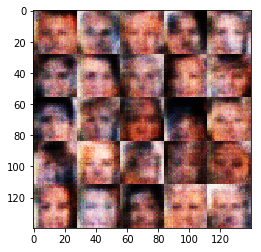

Epoch: 0 of 1 D-loss: 1.0903016328811646 G-loss: 0.7805575132369995


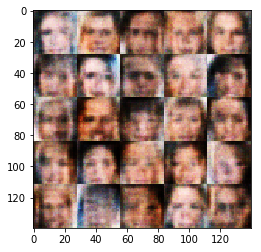

Epoch: 0 of 1 D-loss: 0.7637667655944824 G-loss: 1.1026912927627563


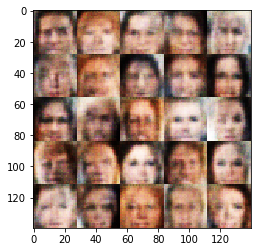

Epoch: 0 of 1 D-loss: 1.0774574279785156 G-loss: 0.7360586524009705


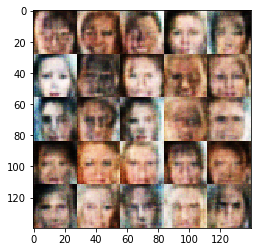

Epoch: 0 of 1 D-loss: 0.7162593007087708 G-loss: 1.1770133972167969


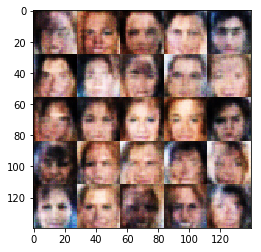

Epoch: 0 of 1 D-loss: 1.0197625160217285 G-loss: 0.8000112175941467


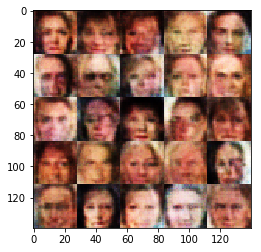

Epoch: 0 of 1 D-loss: 1.2226815223693848 G-loss: 1.1235119104385376


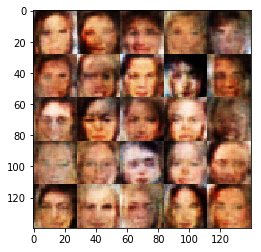

Epoch: 0 of 1 D-loss: 1.1109426021575928 G-loss: 1.240807294845581


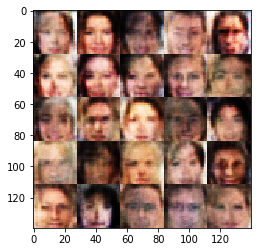

Epoch: 0 of 1 D-loss: 1.4843178987503052 G-loss: 0.6795276403427124


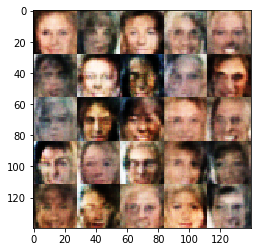

Epoch: 0 of 1 D-loss: 1.1894965171813965 G-loss: 0.7749118804931641


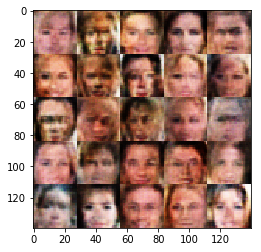

Epoch: 0 of 1 D-loss: 1.3176822662353516 G-loss: 0.8201372623443604


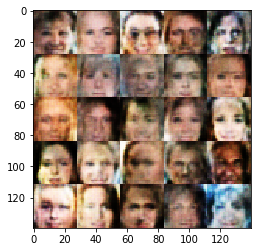

Epoch: 0 of 1 D-loss: 1.1157760620117188 G-loss: 0.7833157181739807


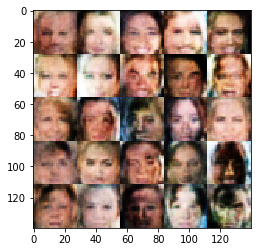

Epoch: 0 of 1 D-loss: 1.2702891826629639 G-loss: 0.9329534769058228


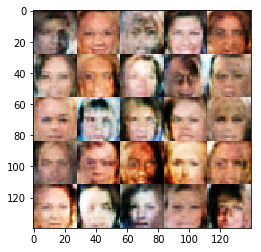

Epoch: 0 of 1 D-loss: 1.2597744464874268 G-loss: 0.7662333250045776


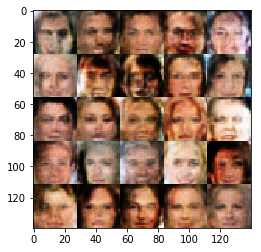

Epoch: 0 of 1 D-loss: 1.001079797744751 G-loss: 0.9559124112129211


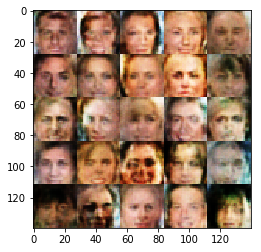

Epoch: 0 of 1 D-loss: 0.9662596583366394 G-loss: 0.9404380321502686


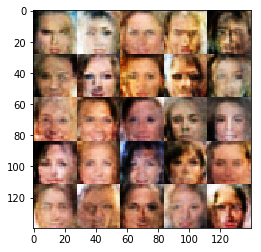

Epoch: 0 of 1 D-loss: 1.1201286315917969 G-loss: 0.9082478284835815


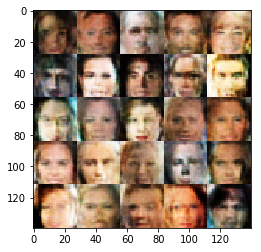

Epoch: 0 of 1 D-loss: 1.2203046083450317 G-loss: 0.6568059921264648


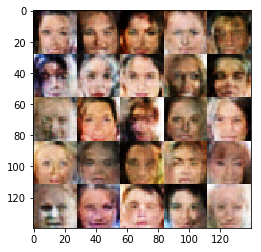

Epoch: 0 of 1 D-loss: 1.1227796077728271 G-loss: 1.2246382236480713


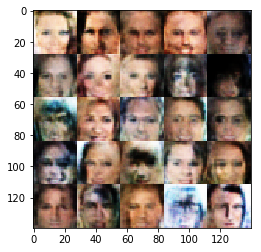

Epoch: 0 of 1 D-loss: 1.1945304870605469 G-loss: 0.6708744168281555


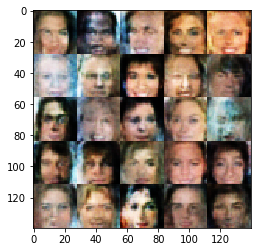

Epoch: 0 of 1 D-loss: 0.9179527759552002 G-loss: 1.2477495670318604


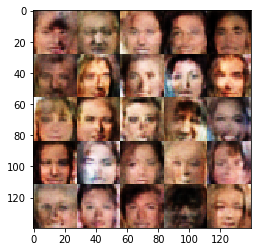

Epoch: 0 of 1 D-loss: 1.0239038467407227 G-loss: 1.0595440864562988


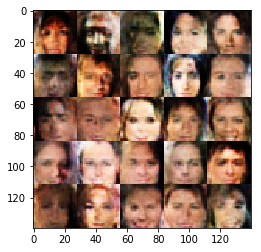

Epoch: 0 of 1 D-loss: 1.0588971376419067 G-loss: 1.0382285118103027


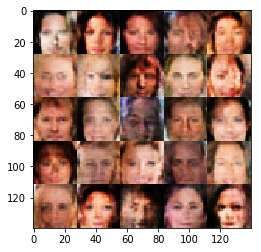

Epoch: 0 of 1 D-loss: 1.0875639915466309 G-loss: 0.8861286044120789


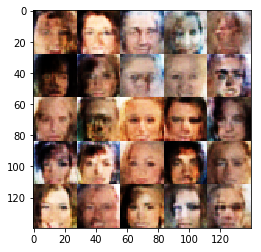

Epoch: 0 of 1 D-loss: 1.1750457286834717 G-loss: 0.6524596214294434


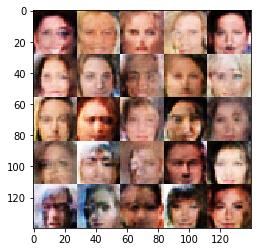

Epoch: 0 of 1 D-loss: 0.9812599420547485 G-loss: 1.2729606628417969


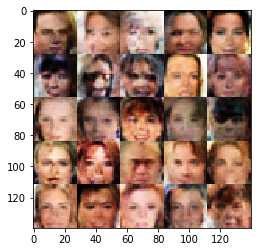

Epoch: 0 of 1 D-loss: 1.0662869215011597 G-loss: 1.1077021360397339


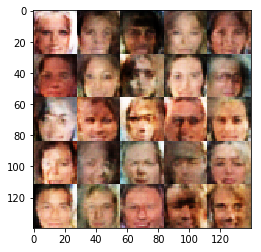

Epoch: 0 of 1 D-loss: 1.2749671936035156 G-loss: 0.7873585224151611


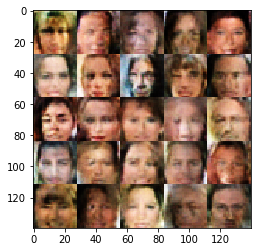

Epoch: 0 of 1 D-loss: 1.1209286451339722 G-loss: 0.9083850979804993


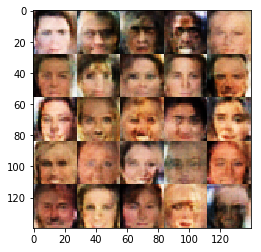

Epoch: 0 of 1 D-loss: 0.9976792931556702 G-loss: 1.0058624744415283


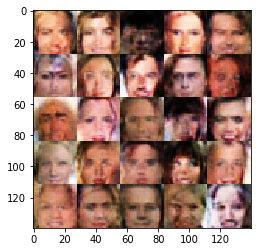

Epoch: 0 of 1 D-loss: 1.0983167886734009 G-loss: 1.0107146501541138


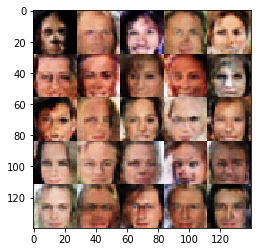

Epoch: 0 of 1 D-loss: 1.0797837972640991 G-loss: 0.8207824230194092


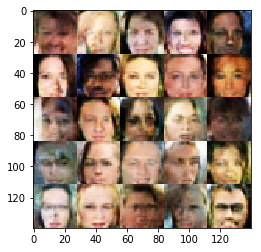

Epoch: 0 of 1 D-loss: 1.295471429824829 G-loss: 0.9446752071380615


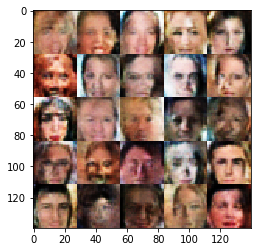

Epoch: 0 of 1 D-loss: 1.1198017597198486 G-loss: 0.77696293592453


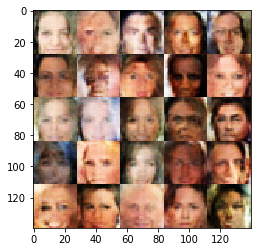

Epoch: 0 of 1 D-loss: 1.1550421714782715 G-loss: 0.6029515266418457


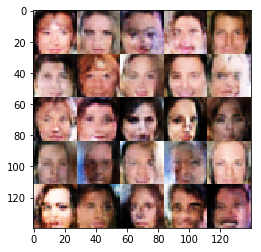

Epoch: 0 of 1 D-loss: 1.182889461517334 G-loss: 0.8296576738357544


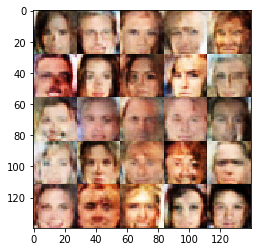

Epoch: 0 of 1 D-loss: 1.1530239582061768 G-loss: 0.7972840666770935


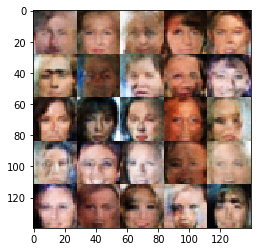

Epoch: 0 of 1 D-loss: 0.9037187695503235 G-loss: 0.8026361465454102


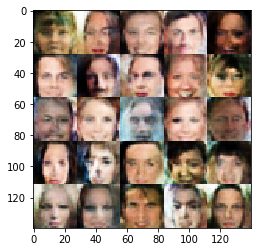

Epoch: 0 of 1 D-loss: 1.0871303081512451 G-loss: 0.7956323623657227


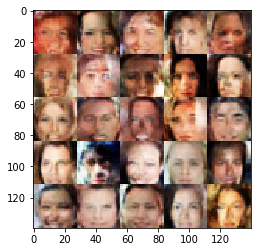

Epoch: 0 of 1 D-loss: 1.0842387676239014 G-loss: 1.1443579196929932


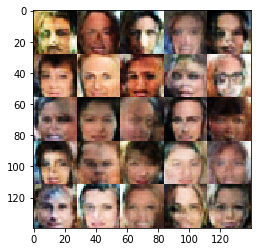

Epoch: 0 of 1 D-loss: 1.1277942657470703 G-loss: 0.7196594476699829


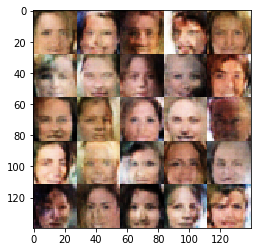

Epoch: 0 of 1 D-loss: 0.9920175671577454 G-loss: 1.0312176942825317


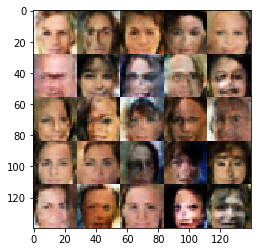

Epoch: 0 of 1 D-loss: 1.1603097915649414 G-loss: 0.7141101956367493


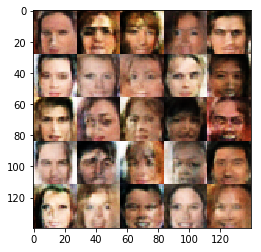

Epoch: 0 of 1 D-loss: 1.4161752462387085 G-loss: 0.5226151943206787


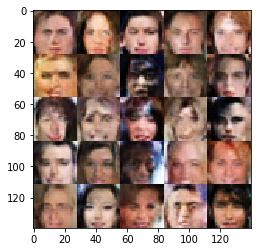

Epoch: 0 of 1 D-loss: 1.0839369297027588 G-loss: 0.7743455171585083


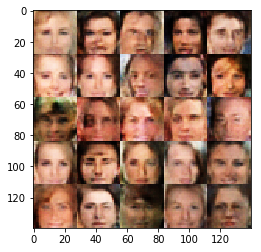

Epoch: 0 of 1 D-loss: 1.274594783782959 G-loss: 0.6414002180099487


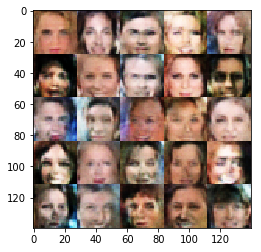

Epoch: 0 of 1 D-loss: 1.2785784006118774 G-loss: 0.5487960577011108


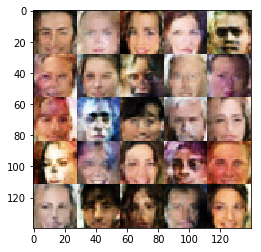

Epoch: 0 of 1 D-loss: 0.9969111084938049 G-loss: 0.864539623260498


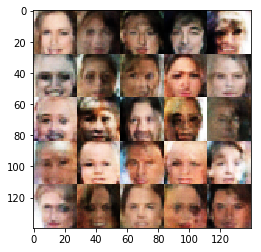

Epoch: 0 of 1 D-loss: 1.2078067064285278 G-loss: 0.5523420572280884


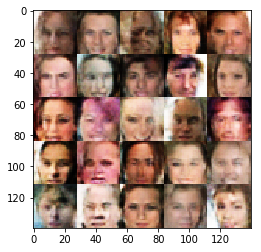

Epoch: 0 of 1 D-loss: 0.90580153465271 G-loss: 1.166633129119873


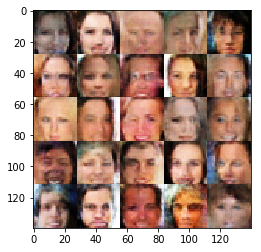

Epoch: 0 of 1 D-loss: 1.1130248308181763 G-loss: 0.9389052391052246


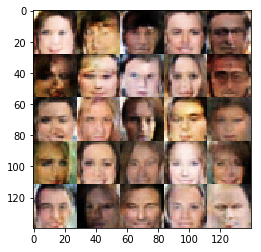

Epoch: 0 of 1 D-loss: 1.4024081230163574 G-loss: 0.5419654250144958


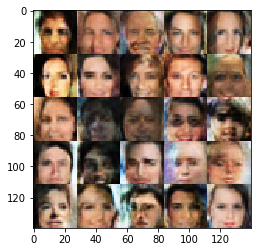

Epoch: 0 of 1 D-loss: 1.0624185800552368 G-loss: 1.0265671014785767


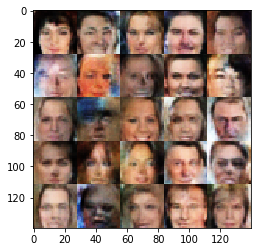

Epoch: 0 of 1 D-loss: 1.510887622833252 G-loss: 0.4908890724182129


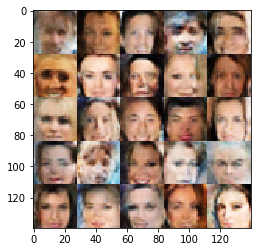

Epoch: 0 of 1 D-loss: 1.134190320968628 G-loss: 0.9539785385131836


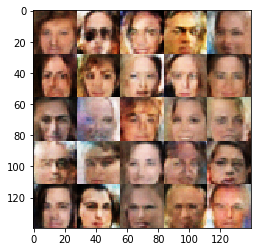

Epoch: 0 of 1 D-loss: 1.302513599395752 G-loss: 0.7047775387763977


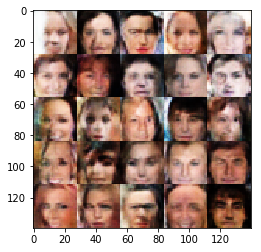

Epoch: 0 of 1 D-loss: 1.0990900993347168 G-loss: 0.8066443204879761


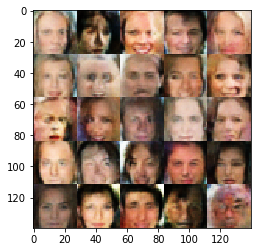

Epoch: 0 of 1 D-loss: 1.0273478031158447 G-loss: 1.012351632118225


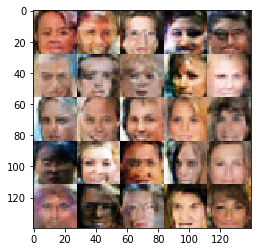

Epoch: 0 of 1 D-loss: 1.0467381477355957 G-loss: 0.8001342415809631


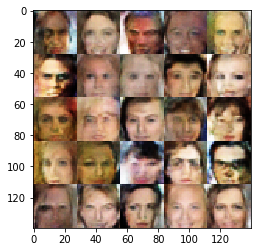

Epoch: 0 of 1 D-loss: 0.9875299334526062 G-loss: 0.8457716703414917


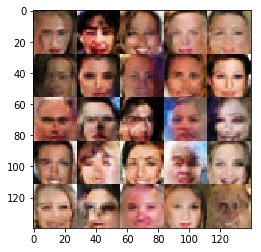

Epoch: 0 of 1 D-loss: 1.1335997581481934 G-loss: 0.7137545347213745


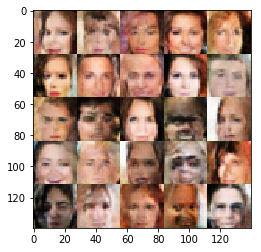

In [24]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.